# MegaFon Accelerator

## 1. Introduction

### 1.1 Task 
Build a model that predicts which of the three segments (0,1,2) each person belongs to.

The contest_train.csv training sample consists of the following columns:  

    * ID - person's id
    * TARGET - segment corresponding to the person.
    * FEATURE_0…FEATURE_259 — person's characteristics.
   
The test sample contest_test.csv consists of an ID column followed by FEATURE_0 ... FEATURE_259.  
The prediction accuracy is assessed using the macro-f1_score metric.

### 1.2 Metric

There are plenty of different metrics to evaluate error. F1 macro is suitable when there is a need to get good results for each class.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.  
F1 macro is the mean value of f1 score each class.


### 1.3 Tools 
The following libraries were used to build the model:
* numpy - A python library for working with arrays.
* pandas - High-level data representation and manipulation tool.
* matplotlib - A library for creating visualizations.
* seaborn - A library for making statistical graphics in Python.
* scipy -  A python library for scientific and mathematical purposes.
* statsmodels - A library for the estimation of many different statistical models.
* sklearn - A library to solve machine learning problems.
* imblearn - Imbalanced-learn toolbox.
* tqdm - progress bar
* catboost - CatBoost is a high-performance open source library for gradient boosting on decision trees

## 2. Implementation

### 2.1 Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
import sklearn
from tqdm import tqdm

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from sklearn.utils import shuffle

In [3]:
import catboost

In [4]:
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LassoCV,SGDClassifier,RidgeClassifier,Lasso,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,RobustScaler,OneHotEncoder
from sklearn.decomposition import PCA

### 2.2 Dataset  overview.

Loading dataset with pandas.

In [5]:
train = pd.read_csv('../mf-accelerator/contest_train.csv')
test = pd.read_csv('../mf-accelerator/contest_test.csv')

Let's look at megafon dataset first 3 rows.

In [6]:
train.head(3)

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,0d1c880d23ff018,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1579ba37fd82c1f,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,790086f721c7f5e,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0


Brief train dataset information about columns.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24521 entries, 0 to 24520
Columns: 262 entries, ID to FEATURE_259
dtypes: float64(260), int64(1), object(1)
memory usage: 49.0+ MB


All values are numeric (exept ID). Hard to get information from table without any meta data about columns.

Amount of missing data in percentage.

In [8]:
(train.isnull().sum()/len(train)*100).sort_values(ascending=False)[:20]

FEATURE_189    98.674605
FEATURE_194    70.327474
FEATURE_190    70.111333
FEATURE_191    62.432201
FEATURE_192    53.260471
FEATURE_193    51.368215
FEATURE_187    48.440113
FEATURE_73     12.071286
FEATURE_71     12.071286
FEATURE_195    11.365768
FEATURE_72     11.341299
FEATURE_153     9.860936
FEATURE_149     9.860936
FEATURE_150     9.860936
FEATURE_151     9.860936
FEATURE_152     9.860936
FEATURE_8       4.665389
FEATURE_188     4.339138
FEATURE_162     2.577383
FEATURE_196     1.904490
dtype: float64

### 2.3 Cleaning data

Some of nan's could contain valubable information. Adding few new binary features for missing data (if data is missing 1 esle 0) should give extra info.

In [9]:
na_col = train.isna().sum()>0
d = {True:1,False:0}
na_columns = list(train.columns[na_col])
for i in na_columns:
    train[i+'_na'] = train.loc[:,i].isna()
    train[i+'_na'] = train[i+'_na'].map(d,i+'_na')
    test[i+'_na'] = test.loc[:,i].isna()
    test[i+'_na'] = test[i+'_na'].map(d,i+'_na')

Most of the machine learning models can't handle with missing data, so cleaning dataset from nan's would be a great idea.  
This function drops columns with 40 or more percentage of missing values.  
And fills 'NaN' with median in numeric and most frequent in categoric column.

In [10]:
def cleaning_na(data):
    '''
    Function for cleaning data
    Drops columns with 40 or more percentage of missing values 
    Fillining 'nan' with median in numeric and most frequent in categoric column
    '''
    columns_with_na = np.where(data.isna().sum()>0)[0]
    columns_to_drop = (data.iloc[:,columns_with_na].isna().sum()/data.shape[0]*100)>40
    columns_number = columns_with_na[np.where((data.iloc[:,columns_with_na].dtypes=='float')|(data.iloc[:,columns_with_na].dtypes=='int'))[0]]
    columns_cat =  columns_with_na[np.where(data.iloc[:,columns_with_na].dtypes=='object')[0]]
    data.iloc[:,columns_number] = data.iloc[:,columns_number].apply(lambda x:x.fillna(x.median()))
    for column in columns_cat:
        data.iloc[:,column].fillna(data.iloc[:,column].mode()[0],inplace=True)
    data.drop(data.columns[columns_with_na[columns_to_drop]],axis=1,inplace=True)
    data.drop('ID',axis=1,inplace=True)

In [11]:
ID = test.ID
cleaning_na(train)
cleaning_na(test)
X = train.drop(['TARGET'],axis=1)
y = train.TARGET

### 2.4 Data visualization

Distribution of target value. TARGET column has a huge disbalance.

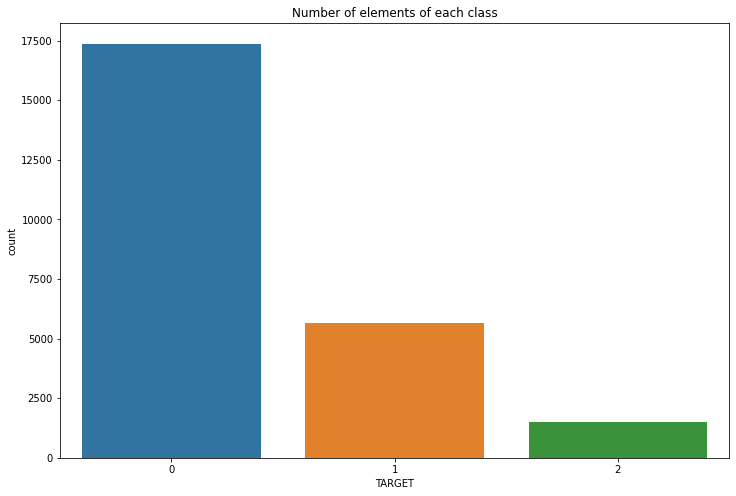

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x=train.TARGET)
plt.title('Number of elements of each class');

Function to separate constant,binary,categorical and discrete columns.

In [13]:
def col_separator(data):
    const_cols = []
    binary_cols = []
    cat_cols = []
    discrete_cols = []
    for i in range(X.shape[1]):
        unique_values = X.iloc[:,i].unique()
        if len(unique_values) == 1:
            const_cols.append(i)
        if len(unique_values) == 2:
            binary_cols.append(i)
        if (len(unique_values) <=50) & (len(unique_values)>2):
            cat_cols.append(i)
        else:
            discrete_cols.append(i)
    return const_cols,binary_cols,cat_cols,discrete_cols
        

In [14]:
const_cols, bin_cols, cat_cols, disc_cols = col_separator(X)

Graph distribution interpretation of each type of data.

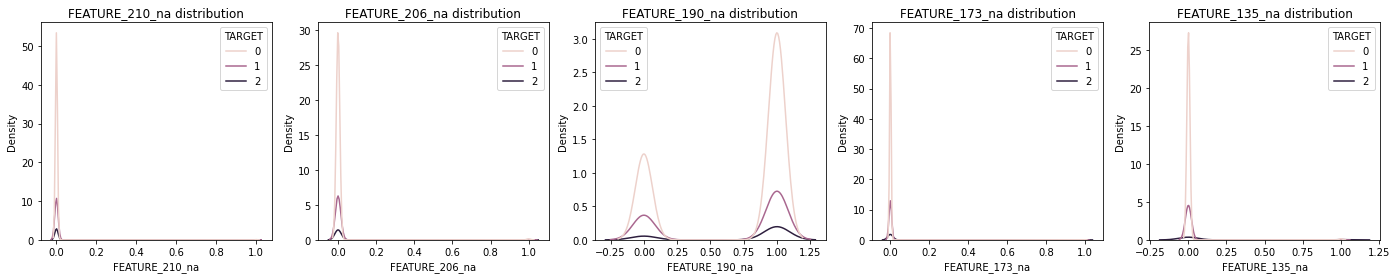

In [15]:
bin_to_draw = np.random.choice(list(X.iloc[:,bin_cols].columns),5)
plt.figure(figsize=(24,4))
for i,feat in enumerate(bin_to_draw):
    plt.subplot(1,5,i+1)
    sns.kdeplot(train.loc[:,feat],hue=y)
    plt.title(f'{feat} distribution');

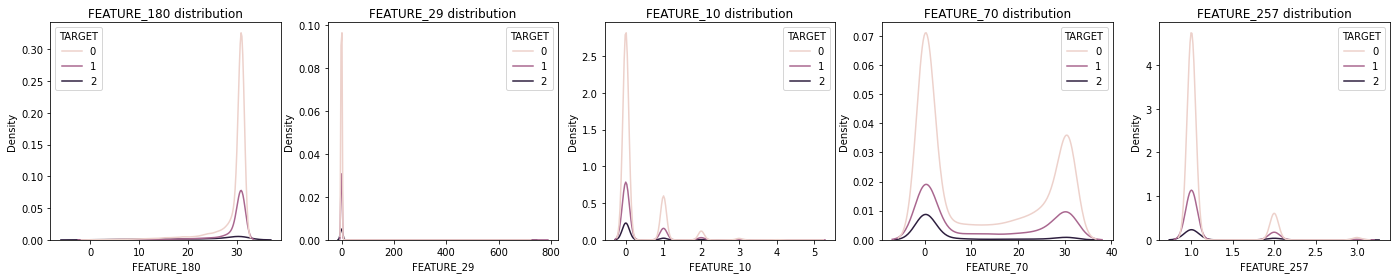

In [16]:
cat_to_draw = np.random.choice(list(X.iloc[:,cat_cols].columns),5)
plt.figure(figsize=(24,4))
for i,feat in enumerate(cat_to_draw):
    plt.subplot(1,5,i+1)
    sns.kdeplot(train.loc[:,feat],hue=y)
    plt.title(f'{feat} distribution');

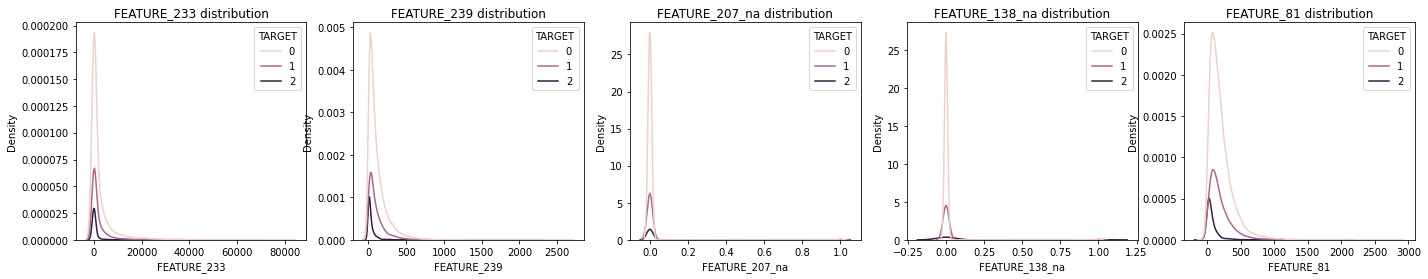

In [18]:
disc_to_draw = np.random.choice(list(X.iloc[:,disc_cols].columns),5)
plt.figure(figsize=(24,4))
for i,feat in enumerate(disc_to_draw):
    plt.subplot(1,5,i+1)
    sns.kdeplot(train.loc[:,feat],hue=y)
    plt.title(f'{feat} distribution');

There are outliars in discrete features. Which can affect bad on building model.

Amount of values in binary features (columns with 95% values of one class or more should be dropped due to its significant disbalance). Also it adds noise.

In [19]:
bin_cols_drop = []
for col in bin_cols:
    if np.bincount(X.iloc[:,col])[0]/sum(np.bincount(X.iloc[:,col]))*100>95:
        bin_cols_drop.append(col)

In [20]:
cols_to_drop = const_cols + bin_cols_drop

In [21]:
X.drop(X.columns[cols_to_drop],axis=1,inplace=True)
test.drop(test.columns[cols_to_drop],axis=1,inplace=True)

## 3. Building model

### 3.1 Comparing ML algorithms.

Function for convinient comparison results.

In [22]:
def evaluate_score(model,X,y):
    ''' 
    Function counts cross-validation score, time (overall train + prediction) of model
    Crossval score is f1_macro, cv = 3
    
    '''
    model_instance = model
    time_before = time.time()
    cvs = cross_val_score(model_instance,X,y,cv=3,scoring='f1_macro',n_jobs=-1).mean()
    time_after = time.time()
    result = pd.DataFrame({'name':model.__class__.__name__,'cross_val_score':cvs,
                           'time':time_after - time_before},index=[0])
    return result

List of ML algorithms for research.

In [23]:
classifiers =  [DecisionTreeClassifier(criterion='entropy',max_depth=8,min_samples_leaf=2,random_state=4),
                RidgeClassifier(alpha = 1.5, max_iter = 2000, random_state=4),
                KNeighborsClassifier(algorithm = 'ball_tree',n_neighbors=3,weights='distance'),
                RandomForestClassifier(criterion='entropy'),
                SGDClassifier(penalty='l1',max_iter=1000,learning_rate='optimal',random_state=4)]

In [24]:
results = pd.DataFrame(columns = ['name','cross_val_score','time'])
for classifier in classifiers:
    results = results.append(evaluate_score(classifier,X,y))    
results.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,RandomForestClassifier,0.376925,18.594860
0,KNeighborsClassifier,0.381468,44.387662
0,RidgeClassifier,0.389199,0.885519
0,DecisionTreeClassifier,0.404433,3.661342
0,SGDClassifier,0.436331,5.063782


### 3.2 Preprocessing

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way.  
Scale features using statistics that are robust to outliers.  
Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [25]:
robust = RobustScaler()
X_robust = robust.fit_transform(X)
test_robust = robust.transform(test)

In [26]:
results_robust = pd.DataFrame(columns = ['name','cross_val_score','time'])
for classifier in classifiers:
    results_robust = results_robust.append(evaluate_score(classifier,X_robust,y))    
results_robust.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,KNeighborsClassifier,0.376753,45.473884
0,RandomForestClassifier,0.377973,18.236672
0,RidgeClassifier,0.390169,0.350186
0,DecisionTreeClassifier,0.404433,2.758160
0,SGDClassifier,0.453029,12.291115


Results improved only for linear models.

### 3.3 Feature selection
Sometimes datasets contain a lot of columns and some of them are irrelevant. Removing features can improve speed and model's perfomance.

#### PCA
PCA is the process of dimensionality reduction by projecting each data point onto only the first few principal components. The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data.

In [27]:
pca = PCA(0.999) #0.999 explained variance
X_pca = pca.fit_transform(X)
X_pca.shape

(24521, 44)

In [28]:
results_pca = pd.DataFrame(columns = ['name','cross_val_score','time'])
for classifier in classifiers:
    results_pca = results_pca.append(evaluate_score(classifier,X_pca,y))    
results_pca.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,SGDClassifier,0.273203,1.493165
0,RidgeClassifier,0.276478,0.168120
0,RandomForestClassifier,0.293589,12.217546
0,DecisionTreeClassifier,0.336342,0.973292
0,KNeighborsClassifier,0.379466,8.492400


#### LassoCV
Lasso (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

In [29]:
selector = feature_selection.SelectFromModel(Lasso(alpha=0.3,random_state=4,max_iter=500)).fit(X,y)
X_sel = selector.transform(X)
X_sel.shape

/Users/borisevich.vd/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.2165943499158, tolerance: 0.8596046735451229
  model = cd_fast.enet_coordinate_descent(


(24521, 53)

In [30]:
results_sel = pd.DataFrame(columns = ['name','cross_val_score','time'])
for classifier in classifiers:
    results_sel = results_sel.append(evaluate_score(classifier,X_sel,y))    
results_sel.sort_values(by='cross_val_score')

,name,cross_val_score,time
0,RidgeClassifier,0.327050,0.186304
0,RandomForestClassifier,0.362866,10.970489
0,KNeighborsClassifier,0.369632,12.400464
0,SGDClassifier,0.371804,3.478886
0,DecisionTreeClassifier,0.377866,0.835572


### 3.4 Class imbalance treatment 
Data are said to suffer the class imbalance problem when the class distributions are highly imbalanced. In this context, many classification learning algorithms have low predictive accuracy for the infrequent class. An important task is to solve the imbalance.

There are could be two directions:
1. Search optimal class weight for model
2. Change dataset distribution  
    2.1 Undersampling  
    2.2 Oversampling

Ridge classifier with class_weight. Class_weight helps model to handle class disbalance.

In [31]:
ridge = RidgeClassifier(random_state=4,alpha=100,max_iter=100,class_weight={0:1,1:2,2:3})
train = shuffle(train)
cvs = cross_val_score(ridge,train.drop(['TARGET'],axis=1),train.TARGET,cv=5,scoring='f1_macro')
cvs.mean()

0.5149407561951709

Making holdout fold. Test set should keep origin class distribution.

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4,stratify=y)

Function to find best class_weight parameters.

In [48]:
def search_class_weight(classifier,X_train,y_train,X_test,y_test,weight0,weight1,weight2):
    f1_max = 0
    for k in tqdm(weight0):
        for i in weight1:
            for j in weight2:
                if classifier == 'ridge':
                    ridge = RidgeClassifier(random_state=4,alpha=100,max_iter=100,
                                            class_weight={0:k,1:i,2:j})
                    ridge.fit(X_train,y_train)
                    pred = ridge.predict(X_test)
                    f1 = f1_score(y_test,ridge.predict(X_test),average="macro")
                if classifier == 'sgd':
                    sgd = SGDClassifier(penalty='l1',max_iter=1000,learning_rate='optimal',
                                          random_state=4,class_weight={0:k,1:i,2:j},n_jobs=-1)
                    sgd.fit(X_train,y_train)
                    pred = sgd.predict(X_test)
                    f1 = f1_score(y_test,sgd.predict(X_test),average="macro")
                if classifier == 'tree':
                    tree = DecisionTreeClassifier(max_depth=8,min_samples_leaf=2,
                                                  random_state=4,class_weight={0:k,1:i,2:j})
                    tree.fit(X_train,y_train)
                    pred = tree.predict(X_test)
                    f1 = f1_score(y_test,tree.predict(X_test),average="macro")
                if f1 > f1_max:
                    f1_max = f1
                    weight_0_f1 = k
                    weight_1_f1 = i
                    weight_2_f1 = j
    return f1_max,weight_0_f1,weight_1_f1,weight_2_f1

In [49]:
f,w1,w2,w3 = search_class_weight('ridge',X_train,y_train,
                                 X_test,y_test,np.arange(0.6,1.2,0.1),
                                 np.arange(1.2,2,0.1),np.arange(2.2,3.3,0.1))


100%|██████████| 6/6 [01:19<00:00, 13.21s/it]


In [50]:
f,w1,w2,w3

(0.5322009602699996, 0.7, 1.7000000000000004, 2.900000000000001)

There are 2 ways to combat with disbalanced target value. They all related with equation of the class quantity. First way is undersampling which makes amount of all classes equal to minority. Another one is oversampling which equal to majority class.

NearMiss algorithms for undersampling dataset. NearMiss version-1 (default version) selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class.

In [36]:
near = NearMiss(sampling_strategy='auto',version=1)
X_under, y_under = near.fit_resample(X_train, y_train)
X_under,y_under = shuffle(X_under,y_under)

In [37]:
y_under.value_counts()

1    1199
2    1199
0    1199
Name: TARGET, dtype: int64

In [38]:
results_under = pd.DataFrame(columns = ['name','cross_val_score','hold_out','time'])
f1_list = []
for classifier in classifiers:
    results_under = results_under.append(evaluate_score(classifier,X_under,y_under))
    classifier.fit(X_under,y_under)
    pred = classifier.predict(X_test)
    f1 = f1_score(y_test,classifier.predict(X_test),average="macro")
    f1_list.append(f1)
results_under['hold_out'] = f1_list
results_under.sort_values(by='cross_val_score')

,name,cross_val_score,hold_out,time
0,KNeighborsClassifier,0.520782,0.179347,1.654082
0,DecisionTreeClassifier,0.556568,0.197531,0.483952
0,SGDClassifier,0.569497,0.171620,1.410851
0,RidgeClassifier,0.619050,0.229080,0.177229
0,RandomForestClassifier,0.643325,0.190697,2.088786


Results turn out bad. Even class weight regulizing doesn't help much.

In [42]:
f,w1,w2,w3 = search_class_weight('tree',X_under,y_under,
                                 X_test,y_test,np.arange(1,3.5,0.5),
                                 np.arange(0.2,0.8,0.1),np.arange(0.5,1.2,0.1))
f,w1,w2,w3

100%|██████████| 5/5 [01:16<00:00, 15.21s/it]


(0.22328557665608106, 3.0, 0.4000000000000001, 0.7)

Synthetic Minority Oversampling Technique. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (basically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [43]:
smote = SMOTE(sampling_strategy='auto',random_state=4)
X_over, y_over = smote.fit_resample(X_train, y_train)
X_over,y_over = shuffle(X_over,y_over)

In [44]:
y_over.value_counts()

2    13897
1    13897
0    13897
Name: TARGET, dtype: int64

In [47]:
results_over = pd.DataFrame(columns = ['name','cross_val_score','hold_out','time'])
f1_list = []
for classifier in classifiers:
    results_over = results_over.append(evaluate_score(classifier,X_over,y_over))
    classifier.fit(X_over,y_over)
    pred = classifier.predict(X_test)
    f1 = f1_score(y_test,classifier.predict(X_test),average="macro")
    f1_list.append(f1)
results_over['hold_out'] = f1_list
results_over.sort_values(by='cross_val_score')

,name,cross_val_score,hold_out,time
0,SGDClassifier,0.554250,0.405886,13.775446
0,RidgeClassifier,0.648070,0.482526,1.059614
0,DecisionTreeClassifier,0.674179,0.440236,6.275412
0,KNeighborsClassifier,0.762893,0.353448,149.124693
0,RandomForestClassifier,0.843078,0.486399,34.432686


Much better than NearMiss strategy. Cross val score is high because many of values are syntetic. Hold out score is evaluated on test size (origin distribution).

In [69]:
f,w1,w2,w3 = search_class_weight('ridge',X_over,y_over,
                                 X_test,y_test,np.arange(0.8,1.2,0.1),
                                 np.arange(0.1,1,0.1),np.arange(0.1,1,0.1))
f,w1,w2,w3

100%|██████████| 4/4 [01:35<00:00, 23.84s/it]


(0.5156846947048166, 1.0, 0.7000000000000001, 0.30000000000000004)

Manual correcting class disbalance by removing majority class values. Rows are chosen randomly.

In [70]:
target_0 = y_train[y_train==0].index
target_1 = y_train[y_train==1].index
target_to_drop_0 = np.random.choice(target_0,10000,replace=False)
target_to_drop_1 = np.random.choice(target_1,2000,replace=False)
to_drop  = np.union1d(target_to_drop_0,target_to_drop_1)
X_res = X_train.drop(to_drop,axis=0)
y_res = y_train.drop(to_drop,axis=0)

In [71]:
results_res = pd.DataFrame(columns = ['name','cross_val_score','hold_out','time'])
f1_list = []
for classifier in classifiers:
    results_res = results_res.append(evaluate_score(classifier,X_res,y_res))
    classifier.fit(X_res,y_res)
    pred = classifier.predict(X_test)
    f1 = f1_score(y_test,classifier.predict(X_test),average="macro")
    f1_list.append(f1)
results_res['hold_out'] = f1_list
results_res.sort_values(by='cross_val_score')

,name,cross_val_score,hold_out,time
0,KNeighborsClassifier,0.428082,0.390898,5.066035
0,SGDClassifier,0.434619,0.466180,1.796333
0,DecisionTreeClassifier,0.473628,0.473661,1.804142
0,RandomForestClassifier,0.508642,0.505112,5.042689
0,RidgeClassifier,0.527784,0.526643,0.735677


In [72]:
f,w1,w2,w3 = search_class_weight('ridge',X_res,y_res,
                                 X_test,y_test,np.arange(0.2,1.1,0.1),
                                 np.arange(0.5,1.2,0.1),np.arange(0.5,1.2,0.1))
f,w1,w2,w3

100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


(0.5282587089635072,
 0.9000000000000001,
 0.9999999999999999,
 0.7999999999999999)

### 3.5 BalancedRandomForestClassifier
Almost the same as original randomforest but it has special possibility for undersampling.

Optimal BalancedRandomForestClassifier hyperparameters.

In [73]:
tree_params = {
    'sampling_strategy':['all'],
    'criterion':['entropy'],
    'max_depth':[None],
    'min_samples_split':[2],
    'min_samples_leaf':[2],
    'min_weight_fraction_leaf':[0],
    'max_features':["auto"],
    'max_leaf_nodes':[None],
    'min_impurity_decrease':[0],
    'bootstrap':[False],
    'replacement':[True],
    'ccp_alpha':[0]
}

In [225]:
f1_max = 0
for i in tqdm(np.arange(0.8,1.8,0.1)):
    for j in np.arange(0.8,1.5,0.1):
        forest = BalancedRandomForestClassifier(n_estimators=500,random_state=4,bootstrap=False,replacement=True,
                                        n_jobs=-1,sampling_strategy={0:7000},
                                        criterion='entropy',class_weight={0:1,1:i,2:j})
        forest.fit(X_train,y_train)
        pred = forest.predict(X_test)
        f1 = f1_score(y_test,forest.predict(X_test),average="macro")
        if f1 > f1_max:
            f1_max = f1
            weight_1_f1 = i
            weight_2_f1 = j

100%|██████████| 10/10 [32:14<00:00, 193.44s/it]


In [75]:
f1_max,weight_1_f1,weight_2_f1

(0.5306333763839487, 1.6999999999999997, 0.9)

Confusion_matrix shows where model faults.

In [94]:
confusion_matrix(y_test,pred)

array([[3344,   13,  118],
       [1028,   19,   83],
       [ 159,    4,  137]])

### 3.6 Catboost

In [221]:
model = catboost.CatBoostClassifier(
    eval_metric='TotalF1:average=Macro',
    loss_function='MultiClass',
    iterations=1000,
    random_seed=4,
    auto_class_weights='Balanced',
    learning_rate=0.02, 
    max_depth = 9, grow_policy='SymmetricTree',
    silent=True,
    l2_leaf_reg = 0.01,
    model_shrink_rate=0.005,
    border_count = 5
)

F1 score on dataset without preprocessing.

In [222]:
model.fit(X_train,y_train)

In [223]:
pred = model.predict(X_test)
f1 = f1_score(y_test,pred,average="macro")
f1

0.5478109440602336

F1 score on dataset after SMOTE.

In [184]:
model.fit(X_over,y_over)

In [185]:
pred = model.predict(X_test)
f1 = f1_score(y_test,pred,average="macro")
f1

0.47824269615507936

F1 score on dataset after NearMiss.

In [186]:
model.fit(X_under,y_under)

In [187]:
pred = model.predict(X_test)
f1 = f1_score(y_test,pred,average="macro")
f1

0.20731828101983615

F1 score on dataset after random undersampling.

In [188]:
model.fit(X_res,y_res)

In [189]:
pred = model.predict(X_test)
f1 = f1_score(y_test,pred,average="macro")
f1

0.525634370633392

## 4. Conclusion

Megafon is huge telecom operator. This task probably is connected with problem of churn clients. On the one hand here much varying columns and data to work with. On the other hand it is hard to find right way of solving problem and hard to do proper feature engineering, preprocessing data because the data is sealed.  
Good results shows ridge classifier with class_weight tuning. Also random forest from imblearn module gives a good shot. Initial undersampling possibility gives fine impact on results. Unfortunately, complex machine learning models like catboost or xgboost demonstates best results without any preprocessing. Catboost f1 macro score is 0.548.